# 目的
ダウンロードしている為替のデータを解析する。

In [1]:
import time
import datetime
import matplotlib.finance as mpf
import matplotlib.dates as mdates
from matplotlib import ticker
from general import drawfigfunc as dff
import os

In [2]:
def datetime2time(dt, unit="sec"):
    """
    datetimeオブジェクトを時間に変換する。
    とりあえず利用するのは日までとする。
    ＜入力＞
        dt: datetimeオブジェクト
        unit: 変換先の単位
    """
    if type(dt) != datetime.datetime:
        raise TypeError
    units = ["sec", "min", "hour", "day"]
    if unit not in units:
        raise ValueError("unit must be in [" + ",".join(units) + "]")
    elif unit == "sec":
        return dt.day*24*60**2 + dt.hour*60**2 + dt.minute*60 + dt.second
    elif unit == "min":
        return dt.day*24*60 + dt.hour*60 + dt.minute + dt.second/60
    elif unit == "hour":
        return dt.day*24 + dt.hour + dt.minute/60 + dt.second/60**2
    elif unit == "day":
        return dt.day + dt.hour/24 + dt.minute/24/60 + dt.second/24/60**2

## データの読み込み

In [15]:
fldrpath = "../data/"
filelist = os.listdir(fldrpath)
print(len(filelist))

126


In [16]:
timestamp = []
data = None
for fname in filelist:
    if data is None:
        _ = pd.read_csv(fldrpath + fname, index_col=0)
        data = _.as_matrix()
        timestamp = list(_.index)
    else:
        _ = pd.read_csv(fldrpath + fname, index_col=0)
        data = np.vstack((data, _))
        timestamp.extend(list(_.index)[:])
#     print(len(_))

In [17]:
len(data), len(timestamp)

(23238, 23238)

## タイムスタンプの加工
プロットできるように加工する

In [18]:
timestamp_ary = np.zeros(len(timestamp), dtype = int)
for ii in range(len(timestamp)):
    stamp = datetime.datetime.strptime(timestamp[ii], "%Y-%m-%d %H:%M:%S")
    timestamp_ary[ii] = stamp.day*24*60**2 + stamp.hour*60**2 + stamp.minute*60 + stamp.second

ind_sort= np.argsort(timestamp_ary)
timestamp_ary = timestamp_ary[ind_sort]
data = data[ind_sort, :]
sub_timestamp = timestamp_ary - timestamp_ary[0]

In [19]:
sub_timestamp

array([     0,      6,     11, ..., 125632, 125638, 125643])

## プロット

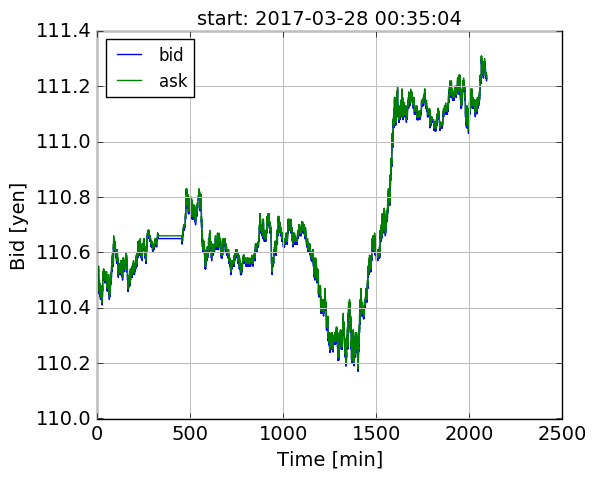

In [20]:
dff.makefig()
plt.plot(sub_timestamp/60, data[:, 1], label="bid")
plt.plot(sub_timestamp/60, data[:, 0], label="ask")
dff.arrangefig(xlabel="Time [min]", ylabel="Bid [yen]", title="start: "+timestamp[0])
plt.legend(loc=2)

# 1分、5分、15分、30分、1時間、1日、1週ごとにローソク足プロットを作成する

## 分割と抽出
* OHLC
* SMA (7, 13, 25 points)
* Differential of trends

### ビンの用意

In [21]:
time_1min = np.arange(timestamp_ary[0], timestamp_ary[-1], 60)
time_5min = np.arange(timestamp_ary[0], timestamp_ary[-1], 5*60)
time_15min = np.arange(timestamp_ary[0], timestamp_ary[-1], 15*60)
time_30min = np.arange(timestamp_ary[0], timestamp_ary[-1], 30*60)
time_1hour = np.arange(timestamp_ary[0], timestamp_ary[-1], 60*60)
time_1day = np.arange(timestamp_ary[0], timestamp_ary[-1], 24*60*60)
time_1week = np.arange(timestamp_ary[0], timestamp_ary[-1], 7*24*60*60)

### OHLCの抽出   

In [22]:
def get_ohlc(fxdata, timestamp, time_edge=None):
    """
    OHLCを抽出する
    Oはstart、Hはmax、Lはmin、cはendで与えられる。
    ＜入力＞
        fxdata: 為替のデータ。(ask, bid)の両方をもつデータを想定
        timestamp: 為替のデータに対応するタイムスタンプ
        time_edge: タイムスタンプを分割するエッジ
    ＜出力＞
        ohlc: OHLCのデータ (len(time_edge), 4) array
              
    """
    ### time_edgeの有効性のチェック
    if time_edge is None: # デフォルトは1 min
        edges = np.arange(timestamp[0], timestamp[-1], 60)
    else:
        edges = time_edge.copy()
    
    ### ohlcの抽出
    ohlc_ask = np.zeros((len(edges), 4), dtype=float)
    ohlc_bid = np.zeros((len(edges), 4), dtype=float)
    for ii in range(len(edges)):
        if ii < len(edges)-1:
            ind = (timestamp>=edges[ii])&(timestamp<edges[ii+1])
        else:
            ind = (timestamp>=edges[ii])
        if ind.sum() != 0:
            asks = fxdata[ind, 0]
            bids = fxdata[ind, 1]
            ohlc_ask[ii] = np.array([asks[0], asks.max(), asks.min(), asks[-1]])
            ohlc_bid[ii] = np.array([bids[0], bids.max(), bids.min(), bids[-1]])
    return ohlc_bid, ohlc_ask

In [23]:
ohlc_bid_1min, ohlc_ask_1min = get_ohlc(data, timestamp_ary, time_1min)
ohlc_bid_5min, ohlc_ask_5min = get_ohlc(data, timestamp_ary, time_5min)
ohlc_bid_15min, ohlc_ask_15min = get_ohlc(data, timestamp_ary, time_15min)
ohlc_bid_30min, ohlc_ask_30min = get_ohlc(data, timestamp_ary, time_30min)
ohlc_bid_1hour, ohlc_ask_1hour = get_ohlc(data, timestamp_ary, time_1hour)

### SMAの計算

In [24]:
def get_sma(close_data, sma_size=[7, 13, 25]):
    """
    Simple Moving Average (SMA)を計算する
    ＜入力＞
        close_data: 終値のデータ列
        sma_size: SMAのサイズ
    ＜出力＞
        sma_dict: SMA
    """
    sma_dict = dict()
    for size in sma_size:
        key = "size{}".format(size)
        sma = []
        for ii in range(len(close_data)):
            sma.append(close_data[max(0, ii-size):ii+1].mean())
        sma_dict[key] = sma
    return sma_dict
    

In [25]:
sma_bid_1min = get_sma(ohlc_bid_1min[:, -1])
sma_bid_5min = get_sma(ohlc_bid_5min[:, -1])
sma_bid_15min = get_sma(ohlc_bid_15min[:, -1])
sma_bid_30min = get_sma(ohlc_bid_30min[:, -1])
sma_bid_1hour = get_sma(ohlc_bid_1hour[:, -1])
keys = list(sma_bid_1min.keys())

## プロット
参考：<http://qiita.com/toyolab/items/1b5d11b5d376bd542022>
```
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
from matplotlib import ticker
import matplotlib.dates as mdates
import pandas as pd

fig = plt.figure()
ax = plt.subplot()

ohlc = np.vstack((range(len(df)), df.values.T)).T #x軸データを整数に
mpf.candlestick_ohlc(ax, ohlc, width=0.8, colorup='r', colordown='b')

xtick0 = (5-df.index[0].weekday())%5 #最初の月曜日のインデックス

plt.xticks(range(xtick0,len(df),5), [x.strftime('%Y-%m-%d') for x in df.index][xtick0::5])
ax.grid(True) #グリッド表示
ax.set_xlim(-1, len(df)) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット
```

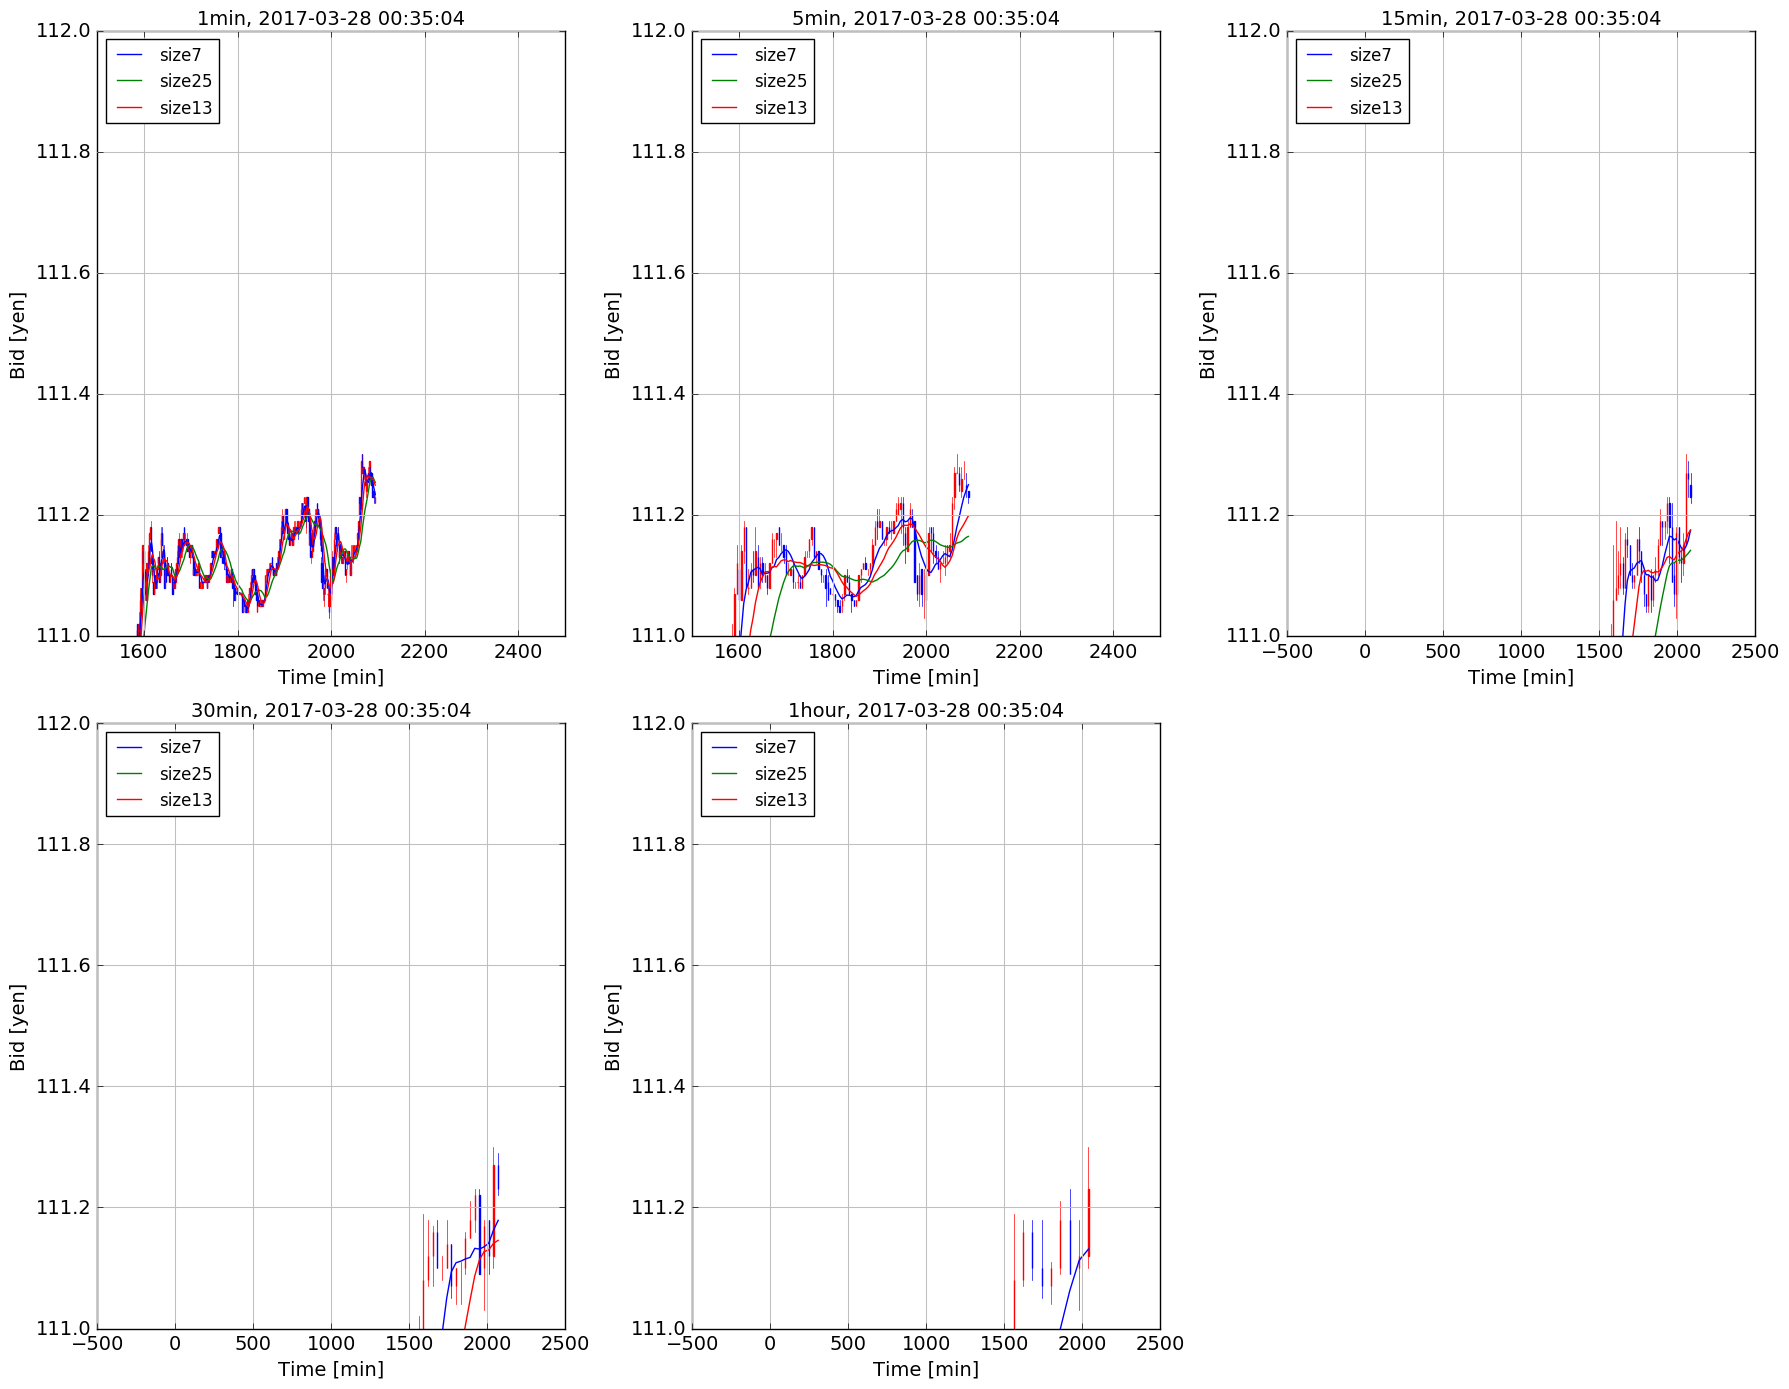

In [28]:
ylim = [111., 112.]
xlim = [1500, 2500]

dff.makefig(18, 14)

# 1min
plt.subplot(2,3,1)
ohlc = np.hstack((((time_1min-time_1min[0])/60)[:, None], ohlc_bid_1min)) #x軸データを整数に
mpf.candlestick_ohlc(plt.gca(), ohlc, width=0.8, colorup='r', colordown='b')
plt.plot((time_1min-time_1min[0])/60, sma_bid_1min.get(keys[0]), label=keys[0])
plt.plot((time_1min-time_1min[0])/60, sma_bid_1min.get(keys[1]), label=keys[1])
plt.plot((time_1min-time_1min[0])/60, sma_bid_1min.get(keys[2]), label=keys[2])
dff.arrangefig(xlabel="Time [min]", ylabel="Bid [yen]", title="1min, "+timestamp[0])
plt.legend(loc=2)

plt.ylim(ylim)
plt.xlim(xlim)

# 5min
plt.subplot(2,3,2)
ohlc = np.hstack((((time_5min-time_5min[0])/60)[:, None], ohlc_bid_5min)) #x軸データを整数に
mpf.candlestick_ohlc(plt.gca(), ohlc, width=0.8, colorup='r', colordown='b')
plt.plot((time_5min-time_5min[0])/60, sma_bid_5min.get(keys[0]), label=keys[0])
plt.plot((time_5min-time_5min[0])/60, sma_bid_5min.get(keys[1]), label=keys[1])
plt.plot((time_5min-time_5min[0])/60, sma_bid_5min.get(keys[2]), label=keys[2])
dff.arrangefig(xlabel="Time [min]", ylabel="Bid [yen]", title="5min, "+timestamp[0])
plt.legend(loc=2)

plt.ylim(ylim)
plt.xlim(xlim)

# 15min
plt.subplot(2,3,3)
ohlc = np.hstack((((time_15min-time_15min[0])/60)[:, None], ohlc_bid_15min)) #x軸データを整数に
mpf.candlestick_ohlc(plt.gca(), ohlc, width=0.8, colorup='r', colordown='b')
plt.plot((time_15min-time_15min[0])/60, sma_bid_15min.get(keys[0]), label=keys[0])
plt.plot((time_15min-time_15min[0])/60, sma_bid_15min.get(keys[1]), label=keys[1])
plt.plot((time_15min-time_15min[0])/60, sma_bid_15min.get(keys[2]), label=keys[2])
dff.arrangefig(xlabel="Time [min]", ylabel="Bid [yen]", title="15min, "+timestamp[0])
plt.legend(loc=2)

plt.ylim(ylim)
# plt.xlim(xlim)

# 30min
plt.subplot(2,3,4)
ohlc = np.hstack((((time_30min-time_30min[0])/60)[:, None], ohlc_bid_30min)) #x軸データを整数に
mpf.candlestick_ohlc(plt.gca(), ohlc, width=0.8, colorup='r', colordown='b')
plt.plot((time_30min-time_30min[0])/60, sma_bid_30min.get(keys[0]), label=keys[0])
plt.plot((time_30min-time_30min[0])/60, sma_bid_30min.get(keys[1]), label=keys[1])
plt.plot((time_30min-time_30min[0])/60, sma_bid_30min.get(keys[2]), label=keys[2])
dff.arrangefig(xlabel="Time [min]", ylabel="Bid [yen]", title="30min, "+timestamp[0])
plt.legend(loc=2)

plt.ylim(ylim)
# plt.xlim(xlim)

# 1hour
plt.subplot(2,3,5)
ohlc = np.hstack((((time_1hour-time_1hour[0])/60)[:, None], ohlc_bid_1hour)) #x軸データを整数に
mpf.candlestick_ohlc(plt.gca(), ohlc, width=0.8, colorup='r', colordown='b')
plt.plot((time_1hour-time_1hour[0])/60, sma_bid_1hour.get(keys[0]), label=keys[0])
plt.plot((time_1hour-time_1hour[0])/60, sma_bid_1hour.get(keys[1]), label=keys[1])
plt.plot((time_1hour-time_1hour[0])/60, sma_bid_1hour.get(keys[2]), label=keys[2])
dff.arrangefig(xlabel="Time [min]", ylabel="Bid [yen]", title="1hour, "+timestamp[0])
plt.legend(loc=2)

plt.ylim(ylim)
# plt.xlim(xlim)
plt.tight_layout()

どうやら1minでの取引を行う場合、5minの転換点（7, 13, 25ポイント平均線がすべて下がるポイント）を目安にすると勝ちになる可能性が高そうである。   
ただしスキャルピングではなく、ややロングターム（30分以上）になるようである。   